In [80]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import torch
from lifelines import KaplanMeierFitter  
import seaborn as sns
device= "cpu"
p = 0.5
a = 5
name = '4.1.png'
n=1000
b = a
def Lambda_0(t):
    l = -np.log(1-p*(1-np.exp(-t)))
    return l
def lambda_0(t):#定义基线风险函数
    expt = np.exp(-t)
    y = p*expt/(1-p*(1-expt))
    return y 
def f(x):
    return np.exp(-x)/x
def H(x,y):
    if y>1000:
        y=np.inf
    h,err = integrate.quad(f,x,y)
    return h
def inv_func1(u,M):
    y = -np.log(1-(1-(1-u)**(1/M))/p)
    return y
def riskmatrix(epsilon,T,delta,G_hat):
    n = len(epsilon)
    t_re = T.reshape((n,1))
    epsilon_re = epsilon.reshape((n,1))
    G = G_hat/G_hat.T
    G[torch.isnan(G)] = 0
    G[torch.isinf(G)] =-0
    R1 = t_re@(torch.ones((1,n)).double()).to(device) <= (t_re@torch.ones((1,n)).double().to(device)).T
    R2 = torch.minimum(t_re@torch.ones((1,n)).double().to(device) >= (t_re@torch.ones((1,n)).double().to(device)).T,torch.ones((n,1)).double().to(device)@(epsilon_re-1).T)
    R2 = torch.minimum(R2,torch.ones((n,1)).double().to(device)@(delta).T)*G
    R = torch.maximum(R1,R2)
    return R
def riskmatrix_add(epsilon,T,delta,G_hat):
    n = len(epsilon)
    t_re = T.reshape((n,1))
    epsilon_re = epsilon.reshape((n,1))
    G = G_hat/G_hat.T
    G[torch.isnan(G)] = 0
    G[torch.isinf(G)] =-0
    R1 = t_re@torch.ones((1,n)).double().to(device) < (t_re@torch.ones((1,n)).double().to(device)).T
    R2 = torch.minimum(t_re@torch.ones((1,n)).double().to(device) >= (t_re@torch.ones((1,n)).double().to(device)).T,torch.ones((n,1)).double().to(device)@(epsilon_re-1).T)
    R2 = torch.minimum(R2,torch.ones((n,1)).double().to(device)@(delta).T)*G
    R = torch.maximum(R1,R2)
    return R
def TP(R,M):
    n = len(M)
    expM_vector = torch.exp(M).reshape(1,n)
    Y_expM_matrix = R*expM_vector#列时间变化，行样本变化
    M_order_matrix = (M.reshape(n,1)>M.reshape(1,n)).double()
    Numerator = Y_expM_matrix@M_order_matrix#T,M
    Denominator = Y_expM_matrix@torch.ones((n,n)).double().to(device)
    TP  = Numerator/Denominator
    return TP
def FP(R_add,M):
    n = len(M)
    M_order_matrix = (M.reshape(n,1)>M.reshape(1,n)).double()
    Numerator = R_add@M_order_matrix#T,M
    Denominator = R_add@torch.ones((n,n)).double().to(device)
    Denominator[Denominator==0]=1
    FP = Numerator/Denominator
    return FP
def G_hat(T,delta):
    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=1-delta)
    km = kmf.survival_function_["KM_estimate"]
    return torch.tensor(km.loc[T[:,0]].values.reshape(len(T[:,0]),1)).to(device)
def auc_t(t):
    L = Lambda_0(t)
    nu = H(2*np.exp(-a)*L,np.exp(b)*2*L)-np.exp(-np.exp(b)*L)*H(np.exp(-a)*L,np.exp(b)*L)
    do = H(np.exp(-a)*L,np.exp(b)*L)*(np.exp(-np.exp(-a)*L)-np.exp(-np.exp(b)*L))
    return nu/do
def auc_t1(t):
    L = Lambda_0(t)
    return H(2*L,np.inf)/(H(L,np.inf)*np.exp(-L))

In [81]:
np.random.seed(1)
M = np.random.uniform(-a, b, n)
u = np.random.uniform(0, 1, n)
U = inv_func1(u,np.exp(M))
C = np.random.uniform(0, 0.5, n)
index1 = (U>0)
index2 = ~index1
epsilon = index2+1.0
np.random.seed(0)
epsilon = (index2+1.0).reshape((n,1))
n2 = (index2).sum()
U[index2] = np.random.uniform(0, 2, n2)
Delta = (U<=C).reshape((n,1))
T = np.minimum(U,C).reshape((n,1))
error =  np.random.normal(0,50/n,n)
M = M+error
M = torch.tensor(M).reshape((n,1)).to(device)
G_hat_i = G_hat(T,Delta)
T_g = torch.tensor(T).to(device)
Delta_g = torch.tensor(Delta).to(device).double()
epsilon_g = torch.tensor(epsilon).to(device)
R = riskmatrix(epsilon_g, T_g, Delta_g, G_hat_i)
R_add = riskmatrix_add(epsilon_g, T_g, Delta_g, G_hat_i)
TP_i = TP(R,M)
FP_i = FP(R_add,M)
auc_array = torch.zeros(n).to(device)
index_M = M[:,0].sort().indices
for j in range(n):
    auc_array[j]=-torch.trapz(y=TP_i[j][index_M], x=FP_i[j][index_M])

In [82]:
auc_array1 = []
for t in list(T[:,0]):
    auc_array1.append(auc_t(t))   

In [83]:
index = T_g[:,0].sort().indices
x = T_g[:,0].sort().values
y = np.arange(1, len(x) + 1) / len(x)
y1 = torch.tensor(auc_array1)[index]
y2 = auc_array[index]
x_t = x.detach().numpy().reshape((1,len(x)))
U_t = U.reshape((len(U),1))
C_t = C.reshape((len(U),1))
size = np.minimum(np.maximum(U_t >= x_t,(epsilon@np.ones((1,len(U))))==2),(C_t@np.ones((1,len(U))))>=np.minimum(U_t@np.ones((1,len(U))),np.ones((len(x),1))@x_t)).sum(axis=0)

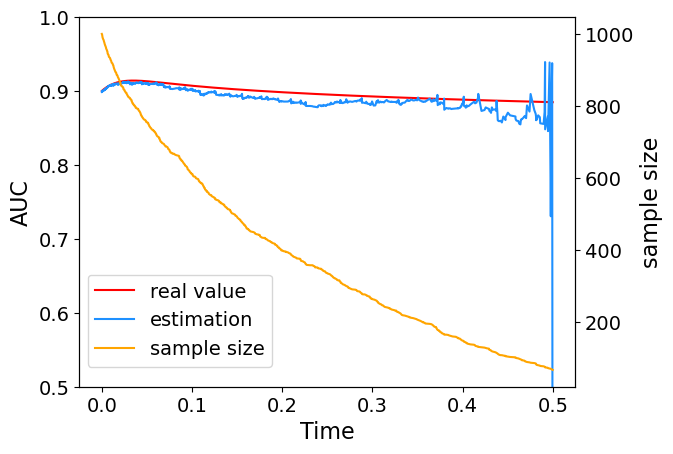

In [84]:
fg = plt.figure()

ax = fg.add_subplot()
ax.plot(x,y1,label='real value', color='red')
ax.plot(x,y2,label='estimation',color='dodgerblue')
ax.set_ylabel('AUC',fontsize=16)
ax.set_xlabel('Time',fontsize=16)
ax.tick_params(labelsize=14)
ax.set_ylim(0.5, 1)
ax2 = ax.twinx()
ax2.set_ylabel('sample size',fontsize=16)
ax2.plot(x,size,label='sample size',color = 'orange')
ax2.tick_params(labelsize=14)
# fg.xticks(fontsize=12)
# fg.yticks(fontsize=12)
fg.legend(loc='lower left',borderaxespad=4.5,fontsize=14)
# ax2.legend(loc='lower left')
fg.savefig(name, dpi=1000,bbox_inches='tight')

In [85]:
len(x)

1000